##                       Facial Emotion, Age and Gender Detection from Images

**Team:**
* Siva Yogitha Mokkapati
* Venkat Nihaal Akula

**Course:** DAAN 897– Deep Learning (Spring II, 2020)

### Problem Statement
* Predicting the emotion from facial images.
* **Keywords:** Classfication, Prediction, Deep Learning, emotion, Neural networks 
	

### Data Collection
* Source(url):(https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
).

* Short Description : The dataset is taken from Kaggle (FER challange).
The dataset has approximately 35000 records, with attributes image pixel array and emotion value.
There are total 7 emotions in the dataset. The dataset has no attributes related to age and gender.

* Keywords: facial emotion, age, gender, pixels,images, prediction

### Required packages
Install the required packages - 
Most of packages are already installed. The syntax for installing packages is pip install package name.

Next the installed package needs to be imported. The syntax is "import package name" or from "package" import "module name".
The packages that are required are:

In [2]:
import numpy as np 
import pandas as pd
import math
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalMaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


<B>Load the dataset and check its shape </B>

In [4]:
image_df= pd.read_csv('C:/Users/sivay/Downloads/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
image_df=image_df[['emotion','pixels']]
print(image_df.head())
print(image_df.shape)

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
(35887, 2)


<b>Download the images from the pixels to a folder named image</b>

In [ ]:
os.mkdir("image")
for index,row in image_df.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((48,48))
    pathname=os.path.join('image',str(index)+'.jpg')
    cv2.imwrite(pathname,img)

<b>Check the emotion values </b>

In [5]:
image_df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

<b>Plot the number of images for each emotion</b>

In [6]:
emotion_label = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
#checking count of each emotion
print(image_df.emotion.value_counts())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


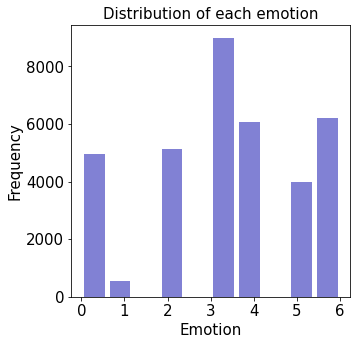

In [7]:
%matplotlib inline
plt.figure(figsize=[5,5])
plt.hist(x=image_df.emotion, color='#0504aa',alpha=0.5, rwidth=0.8)
plt.xlabel('Emotion',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Distribution of each emotion',fontsize=15)
plt.show()

<b>We can see that emotion disguist have very less images</b>

<b>Plot the images for each emotion </b>

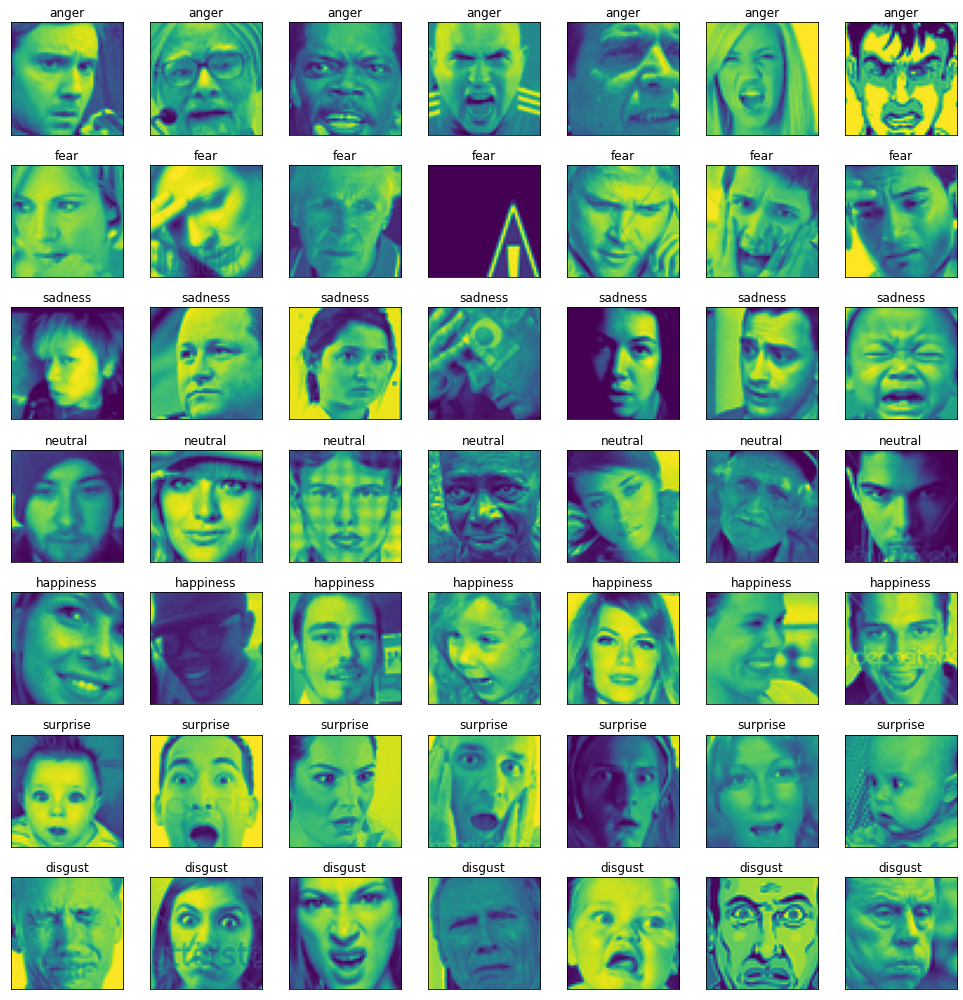

In [8]:
ig = plt.figure(1, (14, 14))
i = 0
for l in image_df.emotion.unique():
    for j in range(7):
        px = image_df[image_df.emotion==l].pixels.iloc[i]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        i += 1
        ax = plt.subplot(7, 7, i)
        ax.imshow(px, cmap=None)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[l])
        plt.tight_layout()

### Data Preprocessing


* The dataset contains image pixels  stored in string format in a data frame. So, the pixels should be separated and converted to float format.
* The pixels should be reshaped to the required format which is (48,48,1). The depth is one because the images are gray scale images.
* Emotion labels are converted to categorical varaibles using label encoder.
* The data is spilitted into test and train.
* The pixels are normalized by dividing with 255.


<b>Convert the pixels from text format to the required shape of float format </b>

In [9]:
image_array = image_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
image_array = np.stack(image_array, axis=0)
print(image_array.shape)

(35887, 48, 48, 1)


<b>We can see that there are total 35887 grey scale images of size 48*48 </b>

<b>Convert the emotions to categorical format</b>

In [10]:
le = LabelEncoder()
image_labels = le.fit_transform(image_df.emotion)
image_labels = tf.keras.utils.to_categorical(image_labels)
image_labels.shape

(35887, 7)

<b>Check the number of classes</b>

In [11]:
le.classes_

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

<b>Split the data to train and validation in the ration 80:20</b>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_array, image_labels,
                                                    shuffle=True, stratify=image_labels,
                                                    test_size=0.2)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(X_train, X_test, y_train, y_test)

<b>Get the image width, height, depth and number of classes to use them while building models</b>

In [13]:
img_width = X_test.shape[1]
img_height = X_test.shape[2]
img_depth = X_test.shape[3]
num_classes = y_test.shape[1]
print(img_width,img_height,img_depth,num_classes)

48 48 1 7


<b>Normalize the data by diving with 255</b>

In [14]:
# Normalizing 
X_train = X_train / 255
X_test = X_test / 255
X_train.shape
y_test.shape

(7178, 7)

<b>Reshape the train and validation data as required to build models. This is only for thr first 2 models</b>

In [13]:
## Run this only for model 1 and 2
X_train = X_train.reshape(len(X_train), 48*48)
X_test = X_test.reshape(len(X_test), 48*48)

## Keras works with floats, so we must cast the numbers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


 ### Methodology

1. To build deep neural networks and convolutional neural networks for emotion detection. To appl transfer learning (VGG) for training the model by making appropriate changes for the VGG model after importing it for emotion detection. To use a pre trained model for gender and age detection.

2. Deep Neural Networks you used in the project
 * ConvNet
    *  A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia) 
 
 * VGG model
    * VGG-19 is a trained Convolutional Neural Network. The number 19 stands for the number of layers with trainable weights. 16 Convolutional layers and 3 Fully Connected layers.
 
 
3. Keywords  
**Keywords:**  supervised learning, transfer learning, classification, prediction, neural networks.

### Model fitting / Validation / Evaluation

1. Model 1
    A basic neural network is built. 2 Dense hidden layers with 64 neurons each with relu activation function and dropout of 0.2 after each layer to prevent outfitting. No data augmentation is used.
    
    

2. Model 2
    6 CNN layers with 32, 64, 128 neurons for each two layers and 2D max pooling layer after every 2 layers. All layers have ‘same’ padding and kernel initializer is ‘he_uniform’ and kernel shape is (3, 3) as the activation function is relu.
    
    
3. Model 3
    CONV => RELU => POOL, drop out 0.25, (CONV => RELLU) * 2 => POOL , dropout 0.25, set of FC => RELU layers, dropout 0.25 and batch normalization after each layer. Data augumentation is applied which is rotation_range=25,width_shift_range=0.1, height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True, fill_mode="nearest



4. Model 4
    Activation function elu, kernel initializer “he_normal”, padding “same”, kernel size (5,5) for first layer and (3,3) for the rest of the layers, dropout 0.4, batch normalization after each layer. Total 6 CNN layers and 2 dense layers at the end. 2D max pooling of (2,2) after every 2 layers. Data augmentation (rotation_range=15,width_shift_range=0.15, height_shift_range=0.15,shear_range=0.15,zoom_range=0.15,horizontal_flip=True)
    
    

5. Model 5 
    Same model 4 with a different output layer that is only for the top 3 emotions.
    
    
    
6. Model 
    Transfer learning (pre trained VGG model) is used. Last 5 layers are removed and 3 dense layers are added as per required. Data augmentation is used.



The optimizer used is Adam optimizer and loss is categorical_crossentropy. Accuracy is used as the performance metrics. Batch size of 64 and 128 are used as required per model. 100 and 25 epochs are used.




<b>Optimal Emotion Detection Model: </b>

* Optimizer: Adam
* Loss Function : Categorical Cross entropy
* Data augmentation : ImageDataGenerator
* Regularization: Drop out, Batch Normalization
* Output Activation Function: Softmax
* Activation Function: Elu 
* Kernel size: (3,3) and (5,5)
* Kernel initializer: he_normal
* Pooling Layers: Max Pooling (2D)



<b>Model 1 with only two hidden dense layers</b>

In [14]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(2304,)))
model_1.add(Dropout(0.2))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(num_classes,
            activation='softmax',
            name='out_layer'))

<b>Complie the model with learning rate 0.001 and using Adam optimizer</b>

In [15]:

# Let's compile the model
learning_rate = .001
model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])
# note that `categorical cross entropy` is the natural generalization 
# of the loss function we had in binary classification case, to multi class case

<b>Fit the model with a batch size of 100 and 25 epochs</b>

In [16]:
# And now let's fit.
batch_size = 128  # mini-batch with 128 examples
epochs = 100
history = model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 2s 78us/sample - loss: 1.8473 - accuracy: 0.2387 - val_loss: 1.7891 - val_accuracy: 0.2572
Epoch 2/100
28709/28709 [==============================] - 2s 54us/sample - loss: 1.7952 - accuracy: 0.2576 - val_loss: 1.7632 - val_accuracy: 0.2764
Epoch 3/100
28709/28709 [==============================] - 1s 48us/sample - loss: 1.7772 - accuracy: 0.2558 - val_loss: 1.7465 - val_accuracy: 0.2806
Epoch 4/100
28709/28709 [==============================] - 1s 50us/sample - loss: 1.7658 - accuracy: 0.2662 - val_loss: 1.7481 - val_accuracy: 0.2828
Epoch 5/100
28709/28709 [==============================] - 1s 48us/sample - loss: 1.7666 - accuracy: 0.2626 - val_loss: 1.7577 - val_accuracy: 0.2778
Epoch 6/100
28709/28709 [==============================] - 1s 47us/sample - loss: 1.7569 - accuracy: 0.2624 - val_loss: 1.7357 - val_accuracy: 0.2892
Epoch 7/100
28709/28709 [==========================

<b>We can see that the accuracy on train is 35.12% and on validation is 34.75% which indicates that the model is underfitting. Also, the train and the validation loss are very high. Hence we need to build a complex model.</b>

<b>Model 2 - A basic CNN model</b>

In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(48,48, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(num_classes,
            activation='softmax',
            name='out_layer'))

<b>Compile the model</b>

In [19]:
# Let's compile the model
learning_rate = .001
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])
# note that `categorical cross entropy` is the natural generalization 
# of the loss function we had in binary classification case, to multi class case

<b>Fit the model with 100 epochs and 128 batch size</b>

In [20]:
# And now let's fit.

batch_size = 128  # mini-batch with 128 examples
epochs = 100
history = model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 1s 48us/sample - loss: 1.6668 - accuracy: 0.3459 - val_loss: 1.6513 - val_accuracy: 0.3515
Epoch 2/100
28709/28709 [==============================] - 1s 48us/sample - loss: 1.6647 - accuracy: 0.3482 - val_loss: 1.6674 - val_accuracy: 0.3396
Epoch 3/100
28709/28709 [==============================] - 1s 45us/sample - loss: 1.6730 - accuracy: 0.3434 - val_loss: 1.6495 - val_accuracy: 0.3519
Epoch 4/100
28709/28709 [==============================] - 1s 45us/sample - loss: 1.6662 - accuracy: 0.3476 - val_loss: 1.6739 - val_accuracy: 0.3546
Epoch 5/100
28709/28709 [==============================] - 1s 47us/sample - loss: 1.6687 - accuracy: 0.3458 - val_loss: 1.6623 - val_accuracy: 0.3529
Epoch 6/100
28709/28709 [==============================] - 1s 45us/sample - loss: 1.6657 - accuracy: 0.3503 - val_loss: 1.6602 - val_accuracy: 0.3526
Epoch 7/100
28709/28709 [==========================

<b>We can see that the accuracy on train is 35.60% and on validation is 33.59% which indicates that the model is underfitting. Also, the train and the validation loss are very high. Hence we need to build a complex model with different activation fucntion is required.</b>

<b>Model 3</b>

In [22]:
inputShape = (img_height, img_width,img_depth)
chanDim=-1
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), padding="same",
input_shape=inputShape))
model2.add(Activation("relu"))
model2.add(BatchNormalization(axis=chanDim))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization(axis=chanDim))
model2.add(Conv2D(128, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization(axis=chanDim))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(1024))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(num_classes))
model2.add(Activation("softmax"))

In [27]:

opt = Adam(lr=0.001, decay=0.001 / 100)
model2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [29]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [36]:
History2 = model2.fit_generator(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 32,
    epochs=100, verbose=1)

Epoch 1/100
897/897 [==============================] - 384s 428ms/step - loss: 2.0175 - accuracy: 0.2455 - val_loss: 8.1409 - val_accuracy: 0.1728
Epoch 2/100
897/897 [==============================] - 272s 303ms/step - loss: 1.8094 - accuracy: 0.2946 - val_loss: 4.4035 - val_accuracy: 0.2028
Epoch 3/100
897/897 [==============================] - 225s 251ms/step - loss: 1.7121 - accuracy: 0.3323 - val_loss: 8.1822 - val_accuracy: 0.1115
Epoch 4/100
897/897 [==============================] - 231s 257ms/step - loss: 1.6537 - accuracy: 0.3606 - val_loss: 7.7165 - val_accuracy: 0.0581
Epoch 5/100
897/897 [==============================] - 227s 253ms/step - loss: 1.5722 - accuracy: 0.3941 - val_loss: 2.6653 - val_accuracy: 0.2051
Epoch 6/100
897/897 [==============================] - 226s 251ms/step - loss: 1.5316 - accuracy: 0.4093 - val_loss: 4.5396 - val_accuracy: 0.1641
Epoch 7/100
897/897 [==============================] - 225s 251ms/step - loss: 1.4899 - accuracy: 0.4238 - val_loss: 6

In [37]:
print("Done")

Done


<b>Model4 </b>

In [15]:
model4 = Sequential()
model4.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(img_width, img_height, img_depth),activation='elu',
                      padding='same',kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.4))
model4.add(Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.4))
model4.add(Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.5, name='dropout_3'))
model4.add(Flatten())   
model4.add( Dense(128,activation='elu',kernel_initializer='he_normal'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(
            num_classes,
            activation='softmax'))

<b>Create Data Augumentation method</b>

In [16]:
a3=ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

<b>Complie the model</b>

In [17]:

opt = Adam(lr=0.001, decay=0.001 / 100)
model4.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

<b>Fit the model using the data augumentation method and the model created</b>

In [30]:
History4 = model4.fit_generator(
	a3.flow(X_train, y_train, batch_size=64),
	validation_data=(X_test, y_test),
	steps_per_epoch=len(X_train) // 64,
	epochs=100, verbose=1)

Epoch 1/100
448/448 [==============================] - 755s 2s/step - loss: 1.0030 - accuracy: 0.6279 - val_loss: 0.9666 - val_accuracy: 0.6443
Epoch 2/100
448/448 [==============================] - 779s 2s/step - loss: 0.9908 - accuracy: 0.6330 - val_loss: 0.9609 - val_accuracy: 0.6445
Epoch 3/100
448/448 [==============================] - 782s 2s/step - loss: 0.9839 - accuracy: 0.6338 - val_loss: 0.9364 - val_accuracy: 0.6538
Epoch 4/100
448/448 [==============================] - 773s 2s/step - loss: 0.9767 - accuracy: 0.6381 - val_loss: 0.9430 - val_accuracy: 0.6517
Epoch 5/100
448/448 [==============================] - 780s 2s/step - loss: 0.9701 - accuracy: 0.6392 - val_loss: 0.9511 - val_accuracy: 0.6481
Epoch 6/100
448/448 [==============================] - 792s 2s/step - loss: 0.9706 - accuracy: 0.6401 - val_loss: 0.9517 - val_accuracy: 0.6519
Epoch 7/100
448/448 [==============================] - 787s 2s/step - loss: 0.9591 - accuracy: 0.6442 - val_loss: 0.9343 - val_accuracy:

total wrong validation predictions: 2287


              precision    recall  f1-score   support

           0       0.66      0.59      0.62       991
           1       0.72      0.50      0.59       109
           2       0.56      0.42      0.48      1024
           3       0.89      0.87      0.88      1798
           4       0.55      0.56      0.56      1216
           5       0.80      0.79      0.79       800
           6       0.57      0.75      0.65      1240

    accuracy                           0.68      7178
   macro avg       0.68      0.64      0.65      7178
weighted avg       0.68      0.68      0.68      7178



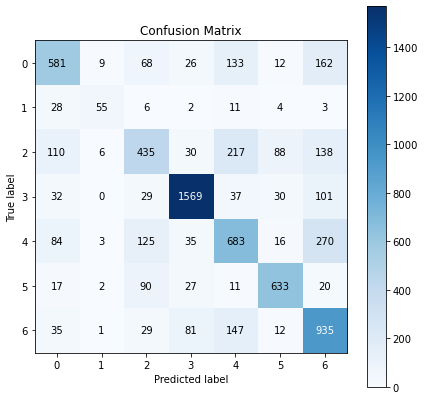

In [33]:
#!pip install scikit-plot
#pip install scikitplot
#import scikitplot
y_valid = model4.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), y_valid, figsize=(7,7))

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != y_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), y_valid))

<b>We can see that the accuracy on train is 73.27% and on validation is 68.14% whihc is the best model as of now</b>

In [ ]:
print("Ok")

<b>CONSIDER ONLY THE TOP 3 EMOTIONS AND BUILD MODELS FOR CLASSIFYING THEM </b>

In [59]:
Il = [3, 4, 6]

In [61]:
image_df1 = image_df[image_df.emotion.isin(Il)]

<b>Get the required data and reshape as required</b>

In [63]:
imagearray = image_df1.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
imagearray = np.stack(imagearray, axis=0)
imagearray.shape
le1 = LabelEncoder()
imagelabels = le1.fit_transform(image_df1.emotion)
imagelabels = tf.keras.utils.to_categorical(imagelabels)
imagelabels.shape
X_train1, X_test1, y_train1, y_test1 = train_test_split(imagearray, imagelabels,
                                                    shuffle=True, stratify=imagelabels,
                                                    test_size=0.3)
imgwidth = X_test1.shape[1]
imgheight = X_test1.shape[2]
imgdepth = X_test1.shape[3]
numclasses = y_test1.shape[1]
print(imgwidth,imgheight,imgdepth,numclasses)
# Normalizing 
X_train1 = X_train1 / 255
X_test1 = X_test1 / 255
X_train1.shape
y_test1.shape

48 48 1 3


(6380, 3)

<b>Build the same model as model4 but with the top 3 labels</b>

In [65]:
model5 = Sequential()
model5.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(img_width, img_height, img_depth),activation='elu',
                      padding='same',kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.4))
model5.add(Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.4))
model5.add(Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.5, name='dropout_3'))
model5.add(Flatten())   
model5.add( Dense(128,activation='elu',kernel_initializer='he_normal'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(
            3,
            activation='softmax'))

<b>Compile the model</b>

In [66]:

opt = Adam(lr=0.001, decay=0.001 / 100)
model5.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

<b>Fit the model</b>

In [67]:
History5 = model5.fit_generator(
    a3.flow(X_train1, y_train1, batch_size=64),
    validation_data=(X_test1, y_test1),
    steps_per_epoch=len(X_train1) // 64,
    epochs=25, verbose=1)

Epoch 1/25
232/232 [==============================] - 767s 3s/step - loss: 1.3141 - accuracy: 0.3994 - val_loss: 1.0325 - val_accuracy: 0.4715
Epoch 2/25
232/232 [==============================] - 771s 3s/step - loss: 1.0794 - accuracy: 0.4574 - val_loss: 0.9544 - val_accuracy: 0.5428
Epoch 3/25
232/232 [==============================] - 780s 3s/step - loss: 1.0006 - accuracy: 0.5088 - val_loss: 0.8799 - val_accuracy: 0.5842
Epoch 4/25
232/232 [==============================] - 903s 4s/step - loss: 0.9405 - accuracy: 0.5456 - val_loss: 0.7978 - val_accuracy: 0.6259
Epoch 5/25
232/232 [==============================] - 495s 2s/step - loss: 0.8636 - accuracy: 0.5894 - val_loss: 0.7579 - val_accuracy: 0.6393
Epoch 6/25
232/232 [==============================] - 510s 2s/step - loss: 0.8096 - accuracy: 0.6165 - val_loss: 0.7682 - val_accuracy: 0.6412
Epoch 7/25
232/232 [==============================] - 514s 2s/step - loss: 0.7582 - accuracy: 0.6414 - val_loss: 0.7837 - val_accuracy: 0.6382

### Transfer learning VGG considering all the emotions

<b>Broadcast the images as required</b>

In [108]:
rgb_batch = np.repeat(X_train[..., np.newaxis], 3, -1)
rgb_batch1 = np.repeat(X_test[..., np.newaxis], 3, -1)
rgb_batch=np.array(rgb_batch)
rgb_batch1=np.array(rgb_batch1)
rgb_batch=rgb_batch.reshape(28709,48,48,3)
rgb_batch1=rgb_batch1.reshape(7178,48,48,3)

<b>Build model using VGG19</b>

In [118]:
model= VGG19(weights="imagenet", include_top=False,pooling='avg',
input_tensor=Input(shape=(img_width, img_height, 3)))

In [119]:
#The last 5 layers ae removed adnd 3 other layers are added
x = model.layers[-5].output
x = GlobalMaxPool2D(name="global_pool")(x)
x = Dense(100, activation="softmax")(x)
x = Dense(30, activation="softmax")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=model.input, outputs=predictions)

In [123]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

<b>Compile the model</b>

In [124]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

<b>Fit the model</b>

In [126]:
History6 = model.fit_generator(
    a3.flow(rgb_batch, y_train, batch_size=64),
    validation_data=(rgb_batch1, y_test),
    steps_per_epoch=len(rgb_batch) // 64,
    epochs=25, verbose=1)

Epoch 1/25
448/448 [==============================] - 1217s 3s/step - loss: 1.8304 - accuracy: 0.2499 - val_loss: 1.8134 - val_accuracy: 0.2505
Epoch 2/25
448/448 [==============================] - 1125s 3s/step - loss: 1.8125 - accuracy: 0.2504 - val_loss: 1.8106 - val_accuracy: 0.2505
Epoch 3/25
448/448 [==============================] - 1124s 3s/step - loss: 1.8109 - accuracy: 0.2505 - val_loss: 1.8101 - val_accuracy: 0.2505
Epoch 4/25
448/448 [==============================] - 1119s 2s/step - loss: 1.8109 - accuracy: 0.2500 - val_loss: 1.8100 - val_accuracy: 0.2505
Epoch 5/25
448/448 [==============================] - 1120s 3s/step - loss: 1.8103 - accuracy: 0.2512 - val_loss: 1.8100 - val_accuracy: 0.2505
Epoch 6/25
448/448 [==============================] - 1116s 2s/step - loss: 1.8105 - accuracy: 0.2505 - val_loss: 1.8099 - val_accuracy: 0.2505
Epoch 7/25
448/448 [==============================] - 1118s 2s/step - loss: 1.8108 - accuracy: 0.2505 - val_loss: 1.8099 - val_accuracy:

In [ ]:
model.save("D:\Deep Learning\model")

In [ ]:
model_1.save("D:\Deep Learning\model1")

In [ ]:
model2.save("D:\Deep Learning\model2")

In [ ]:
model3.save("D:\Deep Learning\model3")

In [35]:
model4.save("D:\Deep Learning\model4")

INFO:tensorflow:Assets written to: D:\Deep Learning\model4\assets


INFO:tensorflow:Assets written to: D:\Deep Learning\model4\assets


In [ ]:
model5.save("D:\Deep Learning\model5")

In [ ]:
#Model1 with basic CNN
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("D:\Deep Learning\plot1")


In [ ]:
#Model 2 with little complex CNN model
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History2.history["loss"], label="train_loss")
plt.plot(N, History2.history["val_loss"], label="val_loss")
plt.plot(N, History2.history["accuracy"], label="train_acc")
plt.plot(N, History2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("D:\Deep Learning\plot2")


In [ ]:
#Model 4 with complex CNN and elu
N = np.arange(0, 25)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History4.history["loss"], label="train_loss")
plt.plot(N, History4.history["val_loss"], label="val_loss")
plt.plot(N, History4.history["accuracy"], label="train_acc")
plt.plot(N, History4.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("D:\Deep Learning\plot4")


In [ ]:
#Model 5 considering only the top 2 lables and complex CNN
N = np.arange(0, 25)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History5.history["loss"], label="train_loss")
plt.plot(N, History5.history["val_loss"], label="val_loss")
plt.plot(N, History5.history["accuracy"], label="train_acc")
plt.plot(N, History5.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("D:\Deep Learning\plot5")

In [ ]:
#model with transfer learning VGG
N = np.arange(0, 25)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History6.history["loss"], label="train_loss")
plt.plot(N, History6.history["val_loss"], label="val_loss")
plt.plot(N, History6.history["accuracy"], label="train_acc")
plt.plot(N, History6.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("D:\Deep Learning\plot")

### Issues / Improvements
1. Lack of effective resources
2. Having only gray scale images for emotion detection.
3. Use cross-validaiton

### References
*	Dehghan, Afshin & Ortiz, Enrique & Shu, Guang & Masood, Syed. (2017). DAGER: Deep Age, Gender and Emotion Recognition Using Convolutional Neural Network.
*	Özdemir, Mehmet & Elagoz, Berkay & Alaybeyoglu, Aysegul & Sadighzadeh, Reza & Akan, Aydin. (2019). Real Time Emotion Recognition from Facial Expressions Using CNN Architecture. 10.1109/TIPTEKNO.2019.8895215.
*	Bargal, Sarah & Barsoum, Emad & Ferrer, Cristian & Zhang, Cha. (2016). Emotion recognition in the wild from videos using images. 433-436. 10.1145/2993148.2997627.

* Slides and notebooks uploaded in canvas.
* Levi, Gil & Hassncer, Tal. (2015). Age and gender classification using convolutional neural networks. 34-42. 10.1109/CVPRW.2015.7301352. 
* Tal Hassner, Shai Harel, Eran Paz, Roee Enbar. Effective Face Frontalization in Unconstrained Images. 
* https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg
* https://towardsdatascience.com/predict-age-and-gender-using-convolutional-neural-network-and-opencv-fd90390e3ce6
* https://www.learnopencv.com/age-gender-classification-using-opencv-deep-learning-c-python/
* https://www.researchgate.net/publication/225173459_Classification_of_Face_Images_for_Gender_Age_Facial_Expression_and_Identity
* https://www.geeksforgeeks.org/image-classifier-using-cnn/
